In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import sklearn.mixture

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.colors


plt.rcParams.update({'font.size': 16, 'font.family': "Times New Roman",
                     'mathtext.fontset': 'cm', 'savefig.format' : 'pdf'})

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import LearningRateScheduler

print(tf.__version__)

Init Plugin
Init Graph Optimizer
Init Kernel
2.5.0


In [3]:
# Define constants
proton_mass=938272088.16
electron_mass=510998.95
pmass= proton_mass+2*electron_mass
light_v=299792458

In [4]:
def interpolate_E(energy,Ncells):
    interpolated = []

    if Ncells>1:
        for i in range(len(energy) - 1):
            increment = (energy[i+1] - energy[i]) / Ncells
            for j in range(Ncells):
                interpolated.append(energy[i] + j * increment)
        interpolated.append(energy[-1])
    else:
        interpolated = energy
        
    return interpolated

In [5]:
def calc_dE(energy):
    dE = []
    if len(energy) >=2:
        for i in range(len(energy) - 1):
            dE.append(energy[i+1] - energy[i])
    dE.append(0)
    
    return dE

In [6]:
def calc_grad(energy,synch_phase):
    grad = np.divide(energy,np.cos(synch_phase/180*np.pi))
    
    return grad

In [7]:
def calc_gamma(energy,mass):
    gamma = np.divide(np.add(energy,mass),mass)
    
    return gamma

In [8]:
def calc_beta(gamma):
    beta = np.sqrt(1 - np.divide(1,gamma**2))
    
    return beta

In [9]:
def calc_L(beta,rf_freq,cavtype):
    light_v=299792458
    
    L=[]
    if cavtype=='SCL': 
        L = np.multiply(beta,light_v/rf_freq/2)
    elif cavtype=='DTL':
        L = np.multiply(beta,light_v/rf_freq)
    else:
        L = np.multiply(beta,light_v/rf_freq) # need to edit for fixed-lenght transition section
    
    #print(beta[:10],L[:10])
    return L

In [10]:
def make_section(cavtype,energy,synch_phase,mass,rf_freq,Ncells,Nmodules):
                 
    E = interpolate_E(energy,Ncells)
    dE = calc_dE(E)
    V = calc_grad(dE,synch_phase)
    G = calc_gamma(E,mass)
    B = calc_beta(G)
    L = calc_L(B,rf_freq,cavtype)
    
    df = pd.DataFrame({'Energy_cell' : E,
                      'dE' : dE,
                      'V' : V,
                      'Gamma' : G,
                      'Beta' : B,
                      'L' : L,
                      'Phi' : synch_phase,
                      'RF' : rf_freq,
                      'Type' : cavtype})
    if cavtype=='SCL':
        # Add drifts  
        for i in range(1,Nmodules):
            n=i*Ncells-1
            df.loc[n+0.5]=df.loc[n+1]
            df.loc[n+0.5,'V']=0
            df.loc[n+0.5,'dE']=0
            df.loc[n+0.5,'L']=float(df.loc[n+0.5,'L']*4)
        df = df.sort_index().reset_index(drop=True)
    
    return df

In [11]:
# Particle propagation

def propagate_Nturns(df,Nturns,init_phase,init_energy):
    
    E = []
    dE = []
    dPhi = []
    l = []

    T_synch=0
    T=0
    energy=0
    total_l=0
    
    for turn in range (0,Nturns):
        
        rf_freq = df.iloc[turn,df.columns.get_indexer(['RF'])].values[0]    
        synch_phase = df.iloc[turn,df.columns.get_indexer(['Phi'])].values[0]
        #synch_energy=df.iloc[turn+1,df.columns.get_indexer(['Energy_cell'])].values[0] #end of turn
        synch_energy=df.iloc[turn,df.columns.get_indexer(['Energy_cell'])].values[0]
        cavtype = df.iloc[turn,df.columns.get_indexer(['Type'])].values[0]
    
        if turn==0:
            T_synch=0
            T=(init_phase - synch_phase)/360.0/rf_freq
            energy=init_energy
            
            dPhi.append(init_phase - synch_phase)
            dE.append(init_energy - synch_energy)
            E.append(init_energy)
            l.append(0)
                    
        
        voltage=df.iloc[turn,df.columns.get_indexer(['V'])].values[0]
        length=df.iloc[turn,df.columns.get_indexer(['L'])].values[0]
 
        total_l=total_l+length

        gamma=(pmass+energy)/pmass
        beta=np.sqrt(1-1/gamma/gamma)
        
        # advance T_synch
        if cavtype=='SCL':
            if voltage==0:
                T_synch = T_synch + 2.0*(1/rf_freq)
            else:
                T_synch = T_synch + 0.5*(1/rf_freq)
        elif cavtype=='DTL':
            if voltage==0:
                T_synch = T_synch + 1/rf_freq ##need to fix - no DTL drift now
            else:
                T_synch = T_synch + 1/rf_freq
                
        else:
            T_synch = T_synch + 21*1/rf_freq ## need to fix
        
        # advance T        
        T=T+length/(beta*light_v)
        
        
        phase_deg = T*rf_freq*360 # T/(1/rf_freq)*2*np.pi*(180/np.pi)

        del_phase =(T-T_synch)*rf_freq*2*np.pi
        energy = energy + voltage*np.cos((synch_phase/180*np.pi)+del_phase)
        synch_energy = synch_energy + voltage*np.cos((synch_phase)/180*np.pi)
        
        del_energy=energy-synch_energy
        del_phase_deg=del_phase*180/np.pi

        dPhi.append(del_phase_deg)
        dE.append(del_energy)
        E.append(energy)
        l.append(total_l)
     
    particle_prop = pd.DataFrame({'E':E,'dE':dE, 'dPhi':dPhi,'l':l})

    return particle_prop


In [12]:
def gen_scan_range(lims,stepsize):
    
    Nsteps = int(abs(lims[1]-lims[0])/stepsize)+1
    scan_range = np.linspace(lims[0],lims[1],Nsteps,endpoint=True)
    
    return scan_range

In [13]:
def phase_scan(scan_range,df,Nturns,e_offset,ph_offset):
    
    initE = []
    endE = []
    initPhi = []
    endPhi = []
    #parts = []
    init_energy = df['Energy_cell'].iloc[0]
    
    for ph in scan_range:
        dfp = propagate_Nturns(df,Nturns,ph+ph_offset,init_energy+e_offset)
        initE.append(dfp['E'].iloc[0])
        endE.append(dfp['E'].iloc[-1])
        initPhi.append(dfp['dPhi'].iloc[0])
        endPhi.append(dfp['dPhi'].iloc[-1])
        #parts.append(dfp)

    cav_response = pd.DataFrame({'cavPhi': scan_range,'initE' : initE, 'endE': endE, 
                                 'initPhi' : initPhi, 'endPhi' : endPhi})

    return cav_response

In [14]:
def chi2_scan(e_offset_range,ph_offset_range,ph_range,df,Nturns,dfdata):
    
    chi2s = []
    cavs = []
    
    # dispersion factors
    D = [-0.4997,-2.224,-1.406]#,0.98]
    var = ['B:HPQ3_E','B:HPQ4_E','B:HPQ5_E']#,'B:VPQ5_E'] ## Effect of autosteer on VPQ5 needs investigation 
    
    for p in ph_offset_range:
        print(p)
        for e in e_offset_range:
            cav_response = phase_scan(ph_range,df,Nturns,e,p)
            cavs.append(cav_response)
            
            # If data & sim have same phase scan range and step size, we can do vector math
            diffs =[((cav_response['endE'] - dfdata[v])**2).sum()/(d**2) for v,d in zip(var,D)]            
            chi2s.append(np.sum(diffs))
            
            # If not we need to do point-wise calculation - uncomment below
            #chi2tot = 0
            #for pp in ph_range:
            #    chi2 = 0
            #    sim = cav_response['endE'].loc[(np.abs(cav_response['initPhi']-pp)<0.2)].iloc[0]
            #    dfslice = dfdata.loc[(np.abs(dfdata['L:L7PADJ']-pp)<0.2)].iloc[0]
            #    for j,d in enumerate(D):
            #        chi2= chi2 +(dfslice[var[j]] - sim)**2/(d**2)
            #    chi2tot = chi2tot+chi2     
            #chi2s.append(chi2tot)       

    return cavs,chi2s

In [15]:
def multi_phase_scan(e_offset_range,ph_offset_range,ph_range,df,Nturns):
    
    cavs = []
    
    for p in ph_offset_range:
        print(p)
        for e in e_offset_range:
            cav_response = phase_scan(ph_range,df,Nturns,e,p)
            
            cavs.append(cav_response)

    return cavs

In [16]:
def extract_dx(cavs):
    
    # dispersion factors
    D = [-0.4997,-2.224,-1.406]#,0.98]
    var = ['B:HPQ3','B:HPQ4','B:HPQ5']#,'B:VPQ5'] ## Effect of autosteer on VPQ5 needs investigation 

    for cav in cavs:

        Eref = cav['endE'].loc[cav['cavPhi']==0].values[0]
        deltaE = cav['endE'] - Eref
        E_t = Eref + 938e6 # pmass

        gamma = E_t/938e6
        beta = np.sqrt(1-(1/gamma)*(1/gamma))

        for i,v in enumerate(var):
            cav[v]= 1000*D[i]*deltaE/E_t/beta/beta 
        

    return(None)

In [17]:
def circle_points(r, n):
    circles = []
    for r, n in zip(r, n):
        t = np.linspace(0, 2*np.pi, n, endpoint=False)
        x = r * np.cos(t)
        y = r * np.sin(t)
        circles.append(np.c_[x, y])
    return circles


initE = 357.1e6 #eV                                                                                                                                          
initPhi = -32 #deg                                                                                                                                        

r = [20] #delta phi in degrees, can take multiple entries                                                                                              
rE = [0.002e6] #delta E in MeV, can take multiple                                                                                                        
n = [10] # number of particles on circle, can take multiple                                                                                          

circles = circle_points(r, n)
#fig, ax = plt.subplots()

# 2D Gaussian
samples = np.random.multivariate_normal([initPhi, initE], [[r[0]**2/4., 1],[1, rE[0]**2/4.]], n[0])

#ax.scatter(samples[:,0],samples[:,1],label='2D Gauss')

for i,circle in enumerate(circles):
    enes = np.add(circle[:,1]/(r[i]/rE[i]),initE)
    phases = np.add(circle[:,0],initPhi)

    #ax.scatter(phases,enes,label='circle')

#fig.legend()

In [18]:
def fetch_data(file,datacols,cuts,setdevs):
    dataset = pd.read_csv(file)
    dataset.columns = dataset.columns.str.replace("[()]", "_",regex=True)

    cols = list(dataset.filter(regex='|'.join(datacols)))

    # for set points, keep _S_ and drop _R_ if available
    cols = [col for col in cols for word in setdevs if col.find(word)==-1]
    
    subset = dataset.loc[:,cols]
    subset.columns = subset.columns.str.replace("_R_|_S_", "",regex=True)
    subset.drop(list(subset.filter(regex=r'\.1|Time|step|iter')),axis=1, inplace=True)

    # apply data quality cuts
    subset.query(cuts,inplace=True)
    
    # augment jumps in phase data
    #subset['B:BQ3F'] = subset['B:BQF3'].apply(lambda x : x if x > 0 else x +360)
    subset.dropna()
    
    print(subset.head())
    
    return subset

In [19]:
# SCL Energy and energy gain per cell from design
energy = np.multiply([357.1,368.1,379.1,390.2,401.5],1e6)

In [20]:
df = make_section('SCL',energy,-32,pmass,805e6,16,4)
df.head(10)
df.tail(10)

,Energy_cell,dE,V,Gamma,Beta,L,Phi,RF,Type
58,395143750.0,706250.0,832794.747374,1.420682,0.710311,0.132265,-32,805000000.0,SCL
59,395850000.0,706250.0,832794.747374,1.421434,0.710680,0.132333,-32,805000000.0,SCL
60,396556250.0,706250.0,832794.747374,1.422185,0.711048,0.132402,-32,805000000.0,SCL
61,397262500.0,706250.0,832794.747374,1.422937,0.711415,0.132470,-32,805000000.0,SCL
62,397968750.0,706250.0,832794.747374,1.423689,0.711782,0.132538,-32,805000000.0,SCL
63,398675000.0,706250.0,832794.747374,1.424441,0.712148,0.132607,-32,805000000.0,SCL
64,399381250.0,706250.0,832794.747374,1.425193,0.712513,0.132674,-32,805000000.0,SCL
65,400087500.0,706250.0,832794.747374,1.425945,0.712877,0.132742,-32,805000000.0,SCL
66,400793750.0,706250.0,832794.747374,1.426697,0.713240,0.132810,-32,805000000.0,SCL
67,401500000.0,0.0,0.000000,1.427449,0.713603,0.132877,-32,805000000.0,SCL


    L:L7PADJ    L:D64BF     L:D74BF    B:HPQ3    B:HPQ4    B:HPQ5    B:VPQ5
0  72.006226  43.341064  112.999878  4.104026  4.708936  5.679242  3.479065
1  72.006226  43.104858  113.236084  4.184235  4.683313  5.556700  3.401084
2  72.006226  43.132324  113.269043  4.097342  4.629841  5.619085  3.430048
3  72.006226  43.203735  113.708496  4.101798  4.783575  5.704864  3.461240
4  72.006226  42.994995  113.796387  4.189805  4.810311  5.656961  3.515827
    L:L7PADJ    L:D64BF     L:D74BF    B:HPQ3    B:HPQ4    B:HPQ5    B:VPQ5
0  72.006226  44.159546  106.875000  3.285226  1.516173  4.042756  5.795099
1  72.006226  44.132080  113.483276  4.029387  4.920598  6.213968  4.154157
2  72.006226  44.340820  113.032837  3.971459  4.687770  6.036840  4.371390
3  72.006226  44.247437  113.389893  4.018247  4.882722  6.212854  4.245506
4  72.006226  44.247437  113.389893  4.098456  5.019746  6.193916  4.253304
L:L7PADJ     82.000732
L:D64BF      43.171326
L:D74BF     107.273254
B:HPQ3        3.386

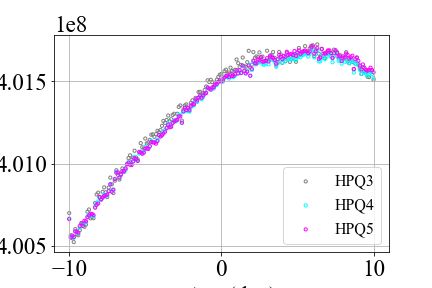

In [188]:
%matplotlib widget

file=r'~/Desktop/LINAC_STUDY/BEAM STUDY 22FEB2023 C7PHAS/devicescanFeb22_2023_72to92.csv'
file2=r'~/Desktop/LINAC_STUDY/BEAM STUDY 20FEB2023/devicescan_TrainingData_Feb202023.csv'

dataset1 = fetch_data(file,['L7PADJ','HPQ3','HPQ4','HPQ5','VPQ5','D64BF','D74BF'],'`L:L7PADJ`>54 & `L:L7PADJ`<96',['L7PADJ_R'])
#subtract reference 
ref = (dataset1.loc[(np.abs(dataset1['L:L7PADJ']-82.)<0.205) & (dataset1['L:L7PADJ']>=82.)]).mean()

dataset1 = dataset1 - ref

dataset2 = fetch_data(file2,['L7PADJ','HPQ3','HPQ4','HPQ5','VPQ5','D64BF','D74BF'],'`L:L7PADJ`>54 & `L:L7PADJ`<96',['L7PADJ_R'])
ref2 = (dataset2.loc[(np.abs(dataset2['L:L7PADJ']-82.)<0.105) & (dataset2['L:L7PADJ']>=82.)]).mean()
dataset2 = dataset2 - ref2

print(ref)
print(ref2)

D = [-0.4997,-2.224,-1.406,0.98]
E_kin=401.5e6
E_t=E_kin+938e6
beta=0.7136

dataset1['B:HPQ3_E']=dataset1['B:HPQ3']/1000/D[0]*beta*beta*E_t+E_kin
dataset1['B:HPQ4_E']=dataset1['B:HPQ4']/1000/D[1]*beta*beta*E_t+E_kin
dataset1['B:HPQ5_E']=dataset1['B:HPQ5']/1000/D[2]*beta*beta*E_t+E_kin
dataset1['B:VPQ5_E']=dataset1['B:VPQ5']/1000/D[3]*beta*beta*E_t+E_kin

dfavg= dataset1.groupby(np.arange(len(dataset1))//10).mean()

dataset2['B:HPQ3_E']=np.add(dataset2['B:HPQ3'],-0.03)/1000/(D[0]*0.92)*beta*beta*E_t+E_kin
dataset2['B:HPQ4_E']=dataset2['B:HPQ4']/1000/(D[1]*0.99999)*beta*beta*E_t+E_kin
dataset2['B:HPQ5_E']=dataset2['B:HPQ5']/1000/(D[2]*0.9999)*beta*beta*E_t+E_kin
dataset2['B:VPQ5_E']=dataset2['B:VPQ5']/1000/D[3]*beta*beta*E_t+E_kin

dfavg2= dataset2.groupby(np.arange(len(dataset2))//10).mean()

#plt.scatter(dfavg['L:L7PADJ'],dfavg['B:HPQ3_E'], label='HPQ3',marker='.',color='k')
#plt.scatter(dfavg['L:L7PADJ'],dfavg['B:HPQ4_E'], label='HPQ4',marker='.',color='b')
#plt.scatter(dfavg['L:L7PADJ'],dfavg['B:HPQ5_E'], label='HPQ5',marker='.',color='r')
#plt.scatter(dfavg['L:L7PADJ'],dfavg['B:VPQ5_E'], label='VPQ5',marker='.',color='orange')

plt.scatter(dfavg2['L:L7PADJ'],dfavg2['B:HPQ3_E'], label='HPQ3',marker='o',s=10,color='grey',facecolors='none')
plt.scatter(dfavg2['L:L7PADJ'],dfavg2['B:HPQ4_E'], label='HPQ4',marker='o',s=10,color='cyan',facecolors='none')
plt.scatter(dfavg2['L:L7PADJ'],dfavg2['B:HPQ5_E'], label='HPQ5',marker='o',s=10,color='magenta',facecolors='none')
#plt.scatter(dfavg2['L:L7PADJ'],dfavg2['B:VPQ5_E'], label='VPQ5',marker='o',color='orange',facecolors='none')

plt.xlabel('$\Delta\phi_{RF}$ (deg)',fontsize='x-large')
plt.ylabel('$E_{out}$ (eV)',fontsize='x-large')
plt.legend(loc='lower right')
#plt.xlim(-10,10)
#plt.ylim(400e6,403e6)
plt.grid()



In [33]:
stepsize = dfavg['L:L7PADJ'].iloc[1] - dfavg['L:L7PADJ'].iloc[0]
stepsize = round(stepsize,2)
print(stepsize)
phaserange = gen_scan_range([-10,10],stepsize)
#Eoff_range = gen_scan_range([-5.7e6,-5.5e6],0.05e6)
Eoff_range = gen_scan_range([-6.75e6,-6.55e6],0.05e6)
Phioff_range = gen_scan_range([-29.6,-29.0],0.10)

#print(phaserange, len(phaserange))
print(Eoff_range, Phioff_range)

0.2
[-6750000. -6700000. -6650000. -6600000. -6550000.] [-29.6 -29.5 -29.4 -29.3 -29.2 -29.1 -29. ]


In [34]:
%%time
cavres1,chi1 = chi2_scan(Eoff_range, Phioff_range, phaserange, df, 67, dfavg)

-29.6
-29.5
-29.400000000000002
-29.3
-29.2
-29.1
-29.0
CPU times: user 3min 1s, sys: 3.16 s, total: 3min 4s
Wall time: 3min 2s


17
    cavPhi        initE          endE  initPhi     endPhi
48    -0.4  350450000.0  4.015193e+08      2.3  43.210890
49    -0.2  350450000.0  4.015337e+08      2.5  43.246247
50     0.0  350450000.0  4.015478e+08      2.7  43.283734
51     0.2  350450000.0  4.015615e+08      2.9  43.323363


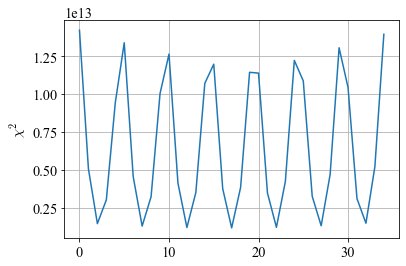

In [35]:
%matplotlib inline

#plt.plot(Eoff_range,test2)
#plt.xlabel('E offset (eV)')
plt.plot(chi1)
plt.ylabel('$\chi^{2}$')
plt.grid()

print(np.argmin(chi1))
print(cavres1[np.argmin(chi1)].iloc[48:52])

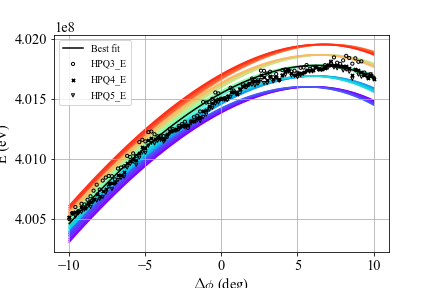

In [36]:
%matplotlib widget

colors = plt.cm.rainbow(np.linspace(0, 1, len(Eoff_range)*len(Phioff_range)))
cols = [colors[i*len(Phioff_range):(i+1)*len(Phioff_range)] for i in range(len(Eoff_range))]

for i,cav in enumerate(cavres1):
    plt.plot(cav['cavPhi'],cav['endE'],linestyle='-',color=cols[i%len(Eoff_range)][int(i/len(Phioff_range))],zorder=1)

plt.plot(cavres1[np.argmin(chi1)]['cavPhi'],cavres1[np.argmin(chi1)]['endE'],linestyle='-',label='Best fit',zorder=2, color='k')

plt.scatter(dfavg['L:L7PADJ'],dfavg['B:HPQ3_E'],marker='o',s=10,facecolors='none',color='k',label='HPQ3_E',zorder=3)
plt.scatter(dfavg['L:L7PADJ'],dfavg['B:HPQ4_E'],marker='x',s=10,color='k',label='HPQ4_E',zorder=3)
plt.scatter(dfavg['L:L7PADJ'],dfavg['B:HPQ5_E'],marker='v',s=10,facecolors='none',color='k',label='HPQ5_E',zorder=3)
#plt.scatter(dfavg['L:L7PADJ'],dfavg['B:VPQ5_E'],marker='s',s=10,facecolors='none',color='k',label='VPQ5_E',zorder=3)


plt.legend()
plt.xlabel('$\Delta \phi$ (deg)')
plt.ylabel('E (eV)')
plt.grid()


In [301]:
stepsize2 = dfavg2['L:L7PADJ'].iloc[1] - dfavg2['L:L7PADJ'].iloc[0]
stepsize2 = round(stepsize2,2)
lim1 = round(dfavg2['L:L7PADJ'].iloc[0],1)
lim2 = round(dfavg2['L:L7PADJ'].iloc[-1],1)
phaserange2 = gen_scan_range([lim1,lim2],stepsize2)
Eoff_range2 = gen_scan_range([-6.775e6,-6.65e6],0.025e6)
Phioff_range2 = gen_scan_range([-28.601,-28.10],0.05)

print(Phioff_range2)
print(Eoff_range2)
print(lim1,lim2,stepsize2)

[-28.601  -28.5509 -28.5008 -28.4507 -28.4006 -28.3505 -28.3004 -28.2503
 -28.2002 -28.1501 -28.1   ]
[-6775000. -6750000. -6725000. -6700000. -6675000. -6650000.]
-10.0 10.0 0.1


In [302]:
%%time
cavres2,chi2 = chi2_scan(Eoff_range2, Phioff_range2, phaserange2, df, 67, dfavg2)

-28.601
-28.5509
-28.500799999999998
-28.4507
-28.4006
-28.3505
-28.3004
-28.2503
-28.200200000000002
-28.150100000000002
-28.1
CPU times: user 11min 23s, sys: 10.9 s, total: 11min 34s
Wall time: 11min 26s


38
cavPhi    -1.000000e+01
initE      3.503750e+08
endE       4.005142e+08
initPhi   -6.300400e+00
endPhi     4.422467e+01
Name: 0, dtype: float64


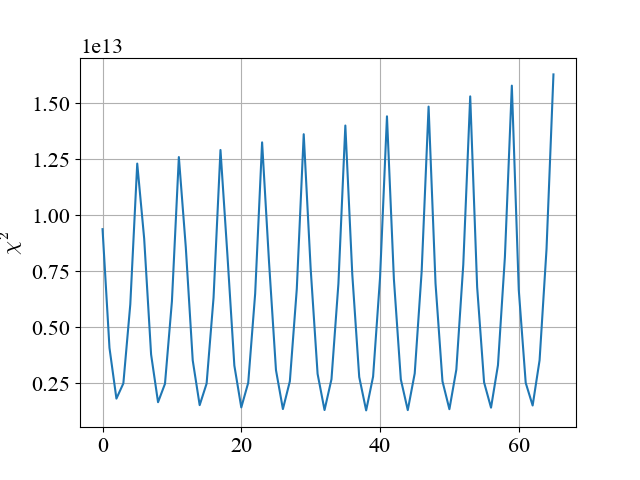

In [438]:
%matplotlib widget 

#plt.plot(Eoff_range,test2)
#plt.xlabel('E offset (eV)')
plt.plot(chi2)
plt.ylabel('$\chi^{2}$')
plt.grid()

print(np.argmin(chi2))
print(cavres2[np.argmin(chi2)].iloc[0])

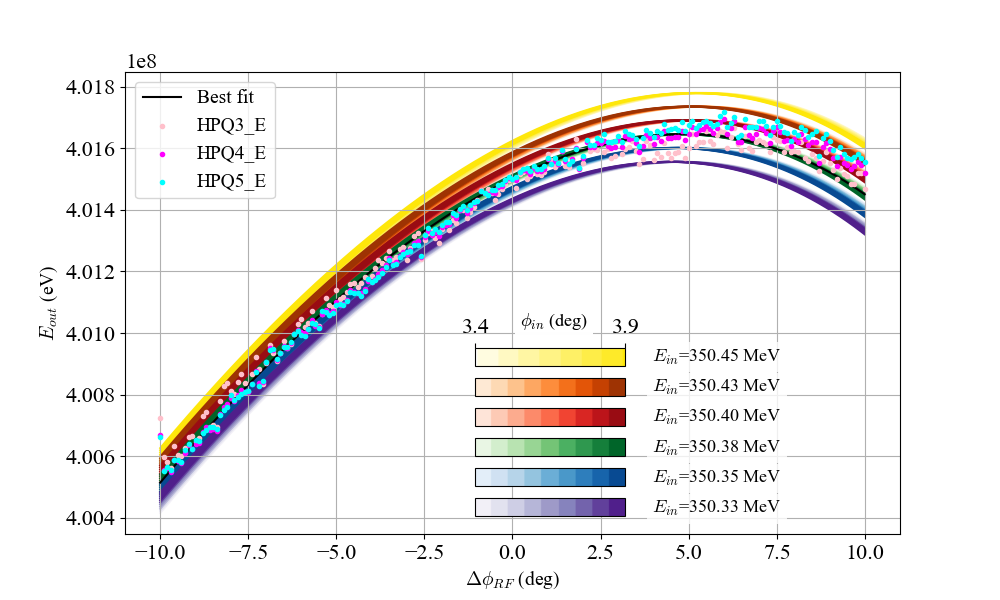

In [454]:
%matplotlib widget

n_lines = len(Phioff_range2)*len(Eoff_range2)
c = np.arange(1., n_lines + 1)

props = dict(boxstyle='square', facecolor='white',edgecolor='None', alpha=0.8)

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

# create yellow colormap
N = len(Phioff_range2)-2
yellow = np.ones((N, 4))
yellow[:, 0] = np.linspace(255/256, 1, N) # R = 255
yellow[:, 1] = np.linspace(232/256, 1, N) # G = 232
yellow[:, 2] = np.linspace(11/256, 1, N)  # B = 11
yellow_cmap = matplotlib.colors.ListedColormap(yellow,'Yellow').reversed()

cmap = plt.get_cmap('rainbow', len(Eoff_range2)*len(Phioff_range2))
maps = ['Purples','Blues','Greens','Reds','Oranges',yellow_cmap]
cmaps=[truncate_colormap(plt.get_cmap(col,len(Phioff_range2)),0.1,0.9) for col in maps]

fig, ax = plt.subplots(figsize=(10,6),dpi=100)
for i,cav in enumerate(cavres2): 
    idx=(i%len(Eoff_range2))*len(Phioff_range2)+int(i/len(Eoff_range2))
    ax.plot(cav['cavPhi'],cav['endE'],linestyle='-',
            color=cmaps[i%len(Eoff_range2)](int(i/len(Eoff_range2))/len(Eoff_range2)),zorder=1)
            #color=cmap(idx),zorder=1)

plt.plot(cavres2[np.argmin(chi2)]['cavPhi'],cavres2[np.argmin(chi2)]['endE'],linestyle='-',label='Best fit',zorder=2, color='k')
plt.scatter(dfavg2['L:L7PADJ'],dfavg2['B:HPQ3_E'],marker='.',label='HPQ3_E',zorder=3,color='pink')
plt.scatter(dfavg2['L:L7PADJ'],dfavg2['B:HPQ4_E'],marker='.',label='HPQ4_E',zorder=3,color='magenta')
plt.scatter(dfavg2['L:L7PADJ'],dfavg2['B:HPQ5_E'],marker='.',label='HPQ5_E',zorder=3,color='cyan')
#plt.scatter(dfavg['L:L7PADJ'],dfavg['B:VPQ5_E'],marker='.',label='VPQ5_E',zorder=3)

#plt.scatter(dfavg2['L:L7PADJ'],dfavg2['B:HPQ3_E'],marker='o',s=10,facecolors='none',color='k',label='HPQ3_E',zorder=3)
#plt.scatter(dfavg2['L:L7PADJ'],dfavg2['B:HPQ4_E'],marker='.',s=10,color='k',label='HPQ4_E',zorder=3)
#plt.scatter(dfavg2['L:L7PADJ'],dfavg2['B:HPQ5_E'],marker='v',s=10,facecolors='none',color='k',label='HPQ5_E',zorder=3)

plt.legend(fontsize=14)
plt.xlabel('$\Delta \phi_{RF}$ (deg)',fontsize=14)
plt.ylabel('$E_{out}$ (eV)',fontsize=14)

for i in range(0,len(Eoff_range2)):
    c_map_ax = fig.add_axes([0.475, 0.14+i*0.05, 0.15, 0.03])
    if i!=len(Eoff_range2)-1:
        c_map_ax.axes.get_xaxis().set_visible(False)
    c_map_ax.axes.get_yaxis().set_visible(False)
    new_cmap = truncate_colormap(cmap, i/len(Eoff_range2), (i+1)/len(Eoff_range2))
    #cbar=matplotlib.colorbar.ColorbarBase(c_map_ax, cmap=new_cmap, orientation = 'horizontal',ticks=[0,1],ticklocation='top')
    cbar=matplotlib.colorbar.ColorbarBase(c_map_ax, cmap=cmaps[i], orientation = 'horizontal',ticks=[0,1],ticklocation='top')
    cbar.set_ticklabels([round(Phioff_range2[0]+32,1), round(Phioff_range2[-1]+32,1)])
    cbar.ax.tick_params(labelsize='medium')
    ax.text(0.68,0.045+i*0.0655,"$E_{in}$=%2.2f MeV"%(Eoff_range2[i]/1e6+357.1),transform=ax.transAxes,
           bbox=props,fontsize=13)
    ax.text(0.51,0.45,"$\phi_{in}$ (deg)",transform=ax.transAxes,
           bbox=props,fontsize=13)


ax.grid()
#plt.show()



In [105]:
trainp = propagate_Nturns(df,67,-29.3,357.1e6-6.65e6)
testp = propagate_Nturns(df,67,-28.5,357.1e6-6.75e6)
testp2 = propagate_Nturns(df,67,-28.5,357.1e6-6.75e6)

350450000.0 350350000.0
2.6999999999999993 3.5
401547807.4452879 401453239.2892137
43.283733780113934 44.527905092241774 44.527905092241774


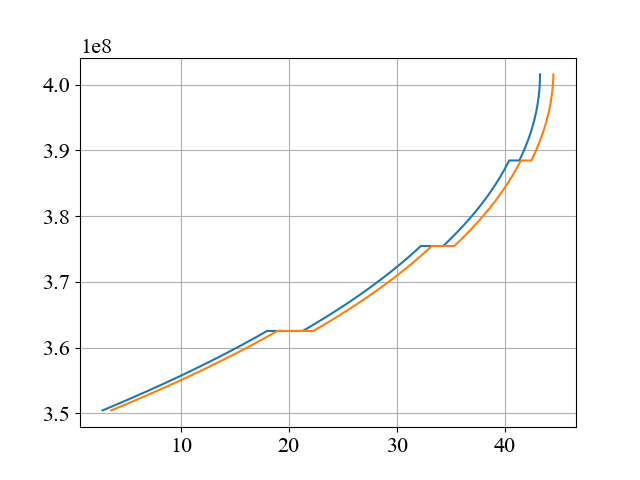

In [106]:
%matplotlib widget
plt.plot(trainp['dPhi'],trainp['E'])
plt.plot(testp['dPhi'],trainp['E'])
plt.grid()
print(trainp['E'].iloc[0],testp['E'].iloc[0])
print(trainp['dPhi'].iloc[0],testp['dPhi'].iloc[0])
print(trainp['E'].iloc[-1],testp['E'].iloc[-1])
print(trainp['dPhi'].iloc[-1],testp['dPhi'].iloc[-1],testp2['dPhi'].iloc[-1])

In [25]:
phaserange1 = gen_scan_range([round(dfavg['L:L7PADJ'].iloc[0],1),
                              round(dfavg['L:L7PADJ'].iloc[-1],1)],
                              round((dfavg['L:L7PADJ'].iloc[1] - dfavg['L:L7PADJ'].iloc[0]),2))
Eoff_range1 = gen_scan_range([-7.5e6,-5.5e6],0.05e6)
Phioff_range1 = gen_scan_range([-30.001,-27.00],0.1)

print(Eoff_range1,Phioff_range1)
print(phaserange1)

[-7500000. -7450000. -7400000. -7350000. -7300000. -7250000. -7200000.
 -7150000. -7100000. -7050000. -7000000. -6950000. -6900000. -6850000.
 -6800000. -6750000. -6700000. -6650000. -6600000. -6550000. -6500000.
 -6450000. -6400000. -6350000. -6300000. -6250000. -6200000. -6150000.
 -6100000. -6050000. -6000000. -5950000. -5900000. -5850000. -5800000.
 -5750000. -5700000. -5650000. -5600000. -5550000. -5500000.] [-30.001      -29.90096667 -29.80093333 -29.7009     -29.60086667
 -29.50083333 -29.4008     -29.30076667 -29.20073333 -29.1007
 -29.00066667 -28.90063333 -28.8006     -28.70056667 -28.60053333
 -28.5005     -28.40046667 -28.30043333 -28.2004     -28.10036667
 -28.00033333 -27.9003     -27.80026667 -27.70023333 -27.6002
 -27.50016667 -27.40013333 -27.3001     -27.20006667 -27.10003333
 -27.        ]
[-10.   -9.8  -9.6  -9.4  -9.2  -9.   -8.8  -8.6  -8.4  -8.2  -8.   -7.8
  -7.6  -7.4  -7.2  -7.   -6.8  -6.6  -6.4  -6.2  -6.   -5.8  -5.6  -5.4
  -5.2  -5.   -4.8  -4.6  -4.4  -4

In [78]:
import itertools
c = list(itertools.product(Eoff_range1, Phioff_range1))

idx = c.index((-6650000.,-29.300766666666668))
print(idx)

Eoffr = gen_scan_range([-7.5e6,-5.5e6],0.5e6)
Phioffr = gen_scan_range([-30.001,-27.00],0.5)
print(Eoffr,Phioffr)


534
[-7500000. -7000000. -6500000. -6000000. -5500000.] [-30.001      -29.50083333 -29.00066667 -28.5005     -28.00033333
 -27.50016667 -27.        ]


In [79]:
simulated = multi_phase_scan(Eoffr, Phioffr, phaserange1, df, 67)

-30.001
-29.500833333333333
-29.000666666666667
-28.500500000000002
-28.000333333333334
-27.500166666666665
-27.0


-29.3


Text(0, 0.5, '$\\Delta x$ (mm)')

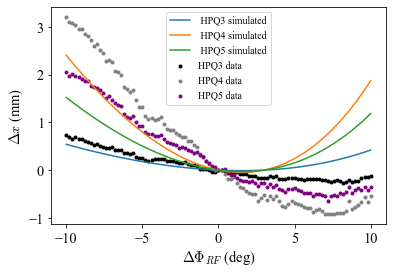

In [32]:
baseline = multi_phase_scan([-6.65e6], [-29.3], phaserange1, df, 67)
cav_response = cavres[534]#simulated[120]

%matplotlib inline
plt.plot(cav_response['cavPhi'],cav_response['B:HPQ3'], label=' HPQ3 simulated')
plt.plot(cav_response['cavPhi'],cav_response['B:HPQ4'], label=' HPQ4 simulated')
plt.plot(cav_response['cavPhi'],cav_response['B:HPQ5'], label=' HPQ5 simulated')
plt.scatter(dfavg['L:L7PADJ'],dfavg['B:HPQ3'], label='HPQ3 data',marker='.',color='k')
plt.scatter(dfavg['L:L7PADJ'],dfavg['B:HPQ4'], label='HPQ4 data',marker='.',color='grey')
plt.scatter(dfavg['L:L7PADJ'],dfavg['B:HPQ5'], label='HPQ5 data',marker='.',color='purple')
plt.legend()
plt.xlabel('$\Delta \Phi_{RF}$ (deg)')
plt.ylabel('$\Delta x$ (mm)')

In [22]:
#[c.to_csv('Mod7_sim_%d.csv.zip'%i) for i,c in enumerate(simulated)]
cavres = []
cavres = [pd.read_csv('Simulated_mod7/Mod7_sim_%d.csv.zip'%i) for i in range(1271)]

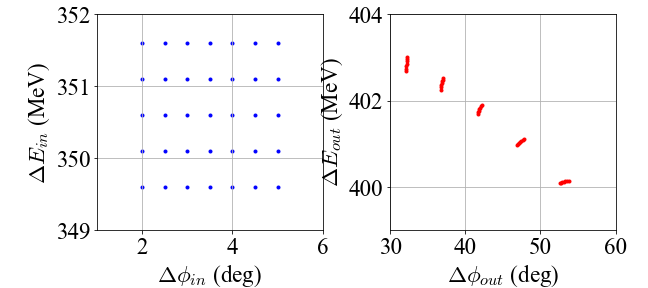

In [83]:
%matplotlib widget
plt.rcParams.update({'font.size': 16, 'font.family': "Times New Roman",
                     'mathtext.fontset': 'cm', 'savefig.format' : 'pdf',
                    'axes.labelsize': 'x-large',
                    'axes.titlesize':'x-large',
                    'xtick.labelsize':'x-large',
                    'ytick.labelsize':'x-large',})


fig,ax = plt.subplots(1,2,figsize=(9,4),sharey=False,sharex=False)

for sim in simulated:
    sim = sim.loc[sim['cavPhi']==0]
    ax[0].scatter(sim['initPhi'],np.divide(sim['initE'],1e6),color='b',marker='.');
    ax[0].grid()
    ax[0].set_ylim(349,352)
    ax[0].set_xlim(1,6)
    ax[0].set(xlabel='$\Delta \phi_{in}$ (deg)', ylabel='$\Delta E_{in}$ (MeV)')
    ax[1].scatter(sim['endPhi'],np.divide(sim['endE'],1e6),color='r',marker='.');
    ax[1].grid()
    ax[1].set_ylim(399,404)
    ax[1].set_xlim(30,60)

    ax[1].set(xlabel='$\Delta \phi_{out}$ (deg)', ylabel='$\Delta E_{out}$ (MeV)')

plt.subplots_adjust(wspace=0.3, hspace=0)
plt.subplots_adjust(bottom=0.2)
plt.subplots_adjust(top=0.95)
plt.subplots_adjust(left=0.15)
plt.subplots_adjust(right=0.95)

In [37]:
baseline = cavres1[np.argmin(chi1)]
baseline = baseline.loc[baseline['cavPhi']==0]
baseline.drop(list(baseline.filter(regex=r'Unn|B:|cav')),axis=1, inplace=True)

alldf = pd.concat(cavres,axis=0)
alldf.reset_index(drop=True,inplace=True)
#alldf.drop(columns=['Unnamed: 0','endE'],inplace=True)
alldf = alldf.loc[alldf['cavPhi']==0]
alldf.drop(list(alldf.filter(regex=r'Unn|B:|cav')),axis=1, inplace=True)
alldf.reset_index(drop=True,inplace=True)
alldf.columns

alldf = alldf-baseline.values.squeeze()
alldf.head()

/var/folders/fl/7z0_lz612sz9d31z6p9fj81h0000gr/T/ipykernel_4906/2064296889.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline.drop(list(baseline.filter(regex=r'Unn|B:|cav')),axis=1, inplace=True)


,initE,endE,initPhi,endPhi
0,-850000.0,-1.456385e+06,-0.701,9.259307
1,-800000.0,-1.359632e+06,-0.701,8.675368
2,-750000.0,-1.264726e+06,-0.701,8.095572
3,-700000.0,-1.171650e+06,-0.701,7.519895
4,-650000.0,-1.080386e+06,-0.701,6.948308


In [64]:
def build_and_compile_model(norm, init_lr):
  model = keras.Sequential([
      norm,
      layers.Dense(20, activation='relu'),#500
      #layers.BatchNormalization(),
      layers.Dense(20, activation='relu'),
      #layers.BatchNormalization(),
      layers.Dense(20, activation='relu'),
      #layers.BatchNormalization(),
      #layers.Dense(50, activation='relu'),
      #layers.BatchNormalization(),
      layers.Dense(1)
  ])

  model.compile(loss='mean_squared_error', steps_per_execution=30,
                optimizer=tf.keras.optimizers.Adam(init_lr))
  return model

def build_and_compile_model_nonorm(inputs, init_lr):
  model = keras.Sequential([
      layers.InputLayer(input_shape=(inputs.shape[1],)),
      layers.Dense(20, activation='relu'),#500
      #layers.BatchNormalization(),
      layers.Dense(20, activation='relu'),
      #layers.BatchNormalization(),
      layers.Dense(20, activation='relu'),
      #layers.BatchNormalization(),
      layers.Dense(20, activation='relu'),
      #layers.BatchNormalization(),
      layers.Dense(20, activation='relu'),
      #layers.Dense(20, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_squared_error', #steps_per_execution=30,
                optimizer=tf.keras.optimizers.Adam(init_lr,decay=1e-3 / 200))
  return model

In [65]:
# Define learning schedules 

initial_lr = 0.001

def lr_time_based_decay(epoch, lr):
    epochs = 400
    decay = initial_lr / epochs
    return lr * 1 / (1 + decay * epoch)


def lr_step_decay(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 200.0
    return initial_lr * math.pow(drop_rate, math.floor(epoch/epochs_drop))

def lr_exp_decay(epoch, lr):
    k = 0.1
    return initial_lr * math.exp(-k*epoch)



In [40]:
def train_model(model,features,labels,eps,lrs=None):
    path_checkpoint = "simulation_model_checkpoint.h5"
    es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

    modelckpt_callback = keras.callbacks.ModelCheckpoint(
        monitor="val_loss",
        filepath=path_checkpoint,
        verbose=1,
        save_weights_only=True,
        save_best_only=True,
    )
    
    if lrs is None:
        history = model.fit(
            features, 
            labels,
            validation_split=0.2,
            batch_size=30, #64
            verbose=0,
            epochs=int(eps),
            callbacks=[es_callback, modelckpt_callback]
        )
    else:
        history = model.fit(
            features, 
            labels, 
            validation_split=0.2,
            batch_size=30,
            verbose=0,
            epochs=int(eps), 
            callbacks=[LearningRateScheduler(lrs, verbose=0)],
        )
    return history

In [41]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    #plt.ylim([0, 4])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

def plot_multi_loss(histories):
    fig, ax = plt.subplots(len(histories),1,figsize=(9,9))
    for i in range(len(histories)):
        ax[i].plot(histories[i].history['loss'], label='loss')
        ax[i].plot(histories[i].history['val_loss'], label='val_loss')
        ax[i].set_ylim([0, 4])
        ax[i].set(xlabel='Epoch', ylabel='Loss')
        ax[i].legend()
        ax[i].grid(True)
        
    fig.tight_layout()


In [42]:
def plot_2dhist(predictions,labels):

    fig, ax = plt.subplots(1,1, figsize=(5,5))
    fig.tight_layout()
    devs = ['Init E']
    
    for i in range(labels.shape[1]):
        key = labels.columns[i]
        #key = devs[i]
        h = ax.hist2d(labels.iloc[:,i], predictions[:,i], bins=40, cmin=1, cmap='winter')
        #ax.set(xlabel='True Values %s'%key, ylabel='Predictions %s'%key)
        #ax.set(title='%s'%key)
        ax.tick_params(axis='both',labelsize='xx-large')
        lims = [min(np.min(predictions[:,i]),np.min(labels.iloc[:,i])),
                max(np.max(predictions[:,i]),np.max(labels.iloc[:,i]))]
        ax.set_xlim(lims)
        ax.set_ylim(lims)
        ax.plot(lims, lims, color='k')
        ax.grid(visible='both',which='major')
        fig.colorbar(h[3], ax=ax)
    fig.supylabel('Predicted $E_{in}$ (eV)', fontsize='xx-large')
    fig.suptitle('True $E_{in}$ (eV)', y=0.05, fontsize='xx-large')   
    plt.subplots_adjust(wspace=0.1, hspace=0)
    plt.subplots_adjust(bottom=0.18)
    plt.subplots_adjust(top=0.92)
    plt.subplots_adjust(left=0.18)
    plt.subplots_adjust(right=0.96)  

In [73]:
def plot_1derror(predictions,labels):
    
    props = dict(boxstyle='round', facecolor='white', alpha=0.4)
    devs = ['phase set point']
    fig, ax = plt.subplots(1,1, figsize=(5,5),sharey=False)
    fig.tight_layout()
    for i in range(labels.shape[1]):
        key = labels.columns[i]
        #key = devs[i]
        error =(predictions[:,i] - labels.iloc[:,i])
        nbins=45
        ax.hist(error, bins=nbins, color='b', edgecolor='k', alpha=0.65, label='Data')
        #ax.set(title='%s'%key ,xlabel='Prediction Error (deg)', ylabel='Count')
        #ax.set(title='%s'%key)
        #ax.xaxis.label.set_size(13)
        #ax.yaxis.label.set_size(13)
        
        ers = np.array(error)[:,None]
        gmm = sklearn.mixture.GaussianMixture()  
        r = gmm.fit(ers)
        mean = r.means_[0, 0]
        sigma = np.sqrt(r.covariances_[0,0])
        textstr = '\n'.join((
                    r'$\mu=%.2f$' % (mean,),
                    r'$\sigma=%.2f$' % (sigma,)))
        print(textstr)                                                                                                                  
        xlin = np.linspace(np.min(error),np.max(error),1000).reshape(-1,1)                                                                                                                             
        pdf = np.exp(gmm.score_samples(xlin))
        binsize = (np.max(error) - np.min(error))/nbins
        ax.plot(xlin,pdf*(len(error)*binsize),color='k', label='Gauss fit')
        ax.text(0.05, 0.65, textstr, transform=ax.transAxes, color='k', fontsize='xx-large',                                                                                
                           verticalalignment='top', bbox=props)
        ax.legend(fontsize='xx-large', loc='upper left')
        ax.tick_params(axis='both',labelsize='xx-large')
        ax.grid(visible='both',which='major')
        
     
    fig.supylabel('Entries/Bin', fontsize='xx-large')
    fig.suptitle('Prediction error (eV)', y=0.05, fontsize='xx-large')
    plt.subplots_adjust(wspace=0.19, hspace=0)
    plt.subplots_adjust(bottom=0.18)
    plt.subplots_adjust(top=0.92)
    plt.subplots_adjust(left=0.18)
    plt.subplots_adjust(right=0.96)  

In [44]:
def fetch_features_labels(dataset,targetdevs):
    features = dataset.copy()
    labelstr = list(dataset.filter(regex='|'.join(targetdevs)))
    labels = features.loc[:,labelstr]
    features.drop(columns=labelstr, inplace=True)
    
    return features,labels

In [45]:
traindata = alldf.sample(frac=0.8, random_state=12)
testdata = alldf.drop(traindata.index)


train_mean = traindata.mean(axis=0)
train_std = traindata.std(axis=0)

testdata = (testdata-train_mean) / train_std
#testdata.head()

traindata = (traindata-train_mean) / train_std
#traindata.head()

train_std

initE      590331.043622
endE       809848.203522
initPhi         0.896739
endPhi          6.179091
dtype: float64

In [46]:
trainft, trainlbl = fetch_features_labels(traindata,['initE'])
testft, testlbl = fetch_features_labels(testdata,['initE'])

In [47]:
trainft.head()
#normalizer = preprocessing.Normalization(axis=-1)
#normalizer.adapt(np.array(trainft))

,endE,initPhi,endPhi
883,0.345843,0.677650,-0.182603
629,-0.401854,0.008336,0.481855
101,-0.069123,-1.441844,0.010911
258,-0.656001,-0.995634,0.621607
818,1.428625,0.454545,-1.528547


In [66]:
%%time


'''
history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)
'''

dnn_model = build_and_compile_model_nonorm(trainft, initial_lr)
dnn_model.summary()
history_time_decay = train_model(dnn_model,trainft,trainlbl,20,lr_step_decay)
dnn_model.save('mod7_simulatedResponse_03052023')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 20)                80        
_________________________________________________________________
dense_20 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_21 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_22 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_23 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 21        
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
____________________________________________________

2023-05-02 07:22:27.703323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-05-02 07:22:27.991662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: mod7_simulatedResponse_03052023/assets
CPU times: user 3.9 s, sys: 2.51 s, total: 6.4 s
Wall time: 4 s


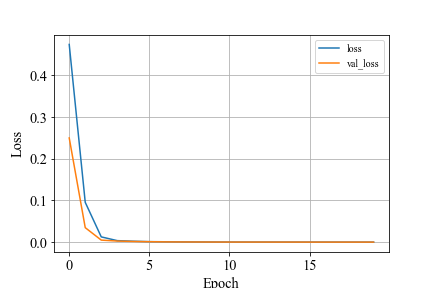

In [67]:
%matplotlib widget
plot_loss(history_time_decay)

In [68]:
test_predictions = dnn_model.predict(testft)
scaledpred = test_predictions* train_std['initE'] + train_mean['initE']
scaledlbl = testlbl* train_std['initE'] + train_mean['initE']

2023-05-02 07:22:35.250922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


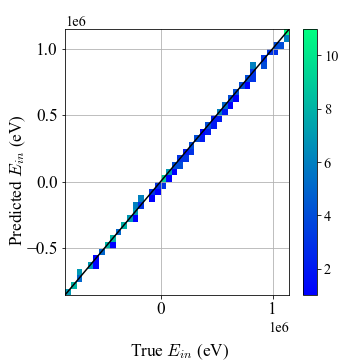

In [69]:
#plot_2dhist(test_predictions,testlbl)

%matplotlib widget
plot_2dhist(scaledpred,scaledlbl)

$\mu=1199.81$
$\sigma=6410.38$


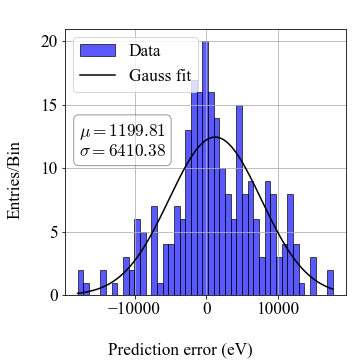

In [74]:
%matplotlib widget
#plot_1derror(test_predictions,testlbl)
plot_1derror(scaledpred,scaledlbl)

In [119]:
file3=r'~/Desktop/LINAC_STUDY/BEAM STUDY 20FEB2023/devicescan_TrainingData_Feb202023.csv'


dataset3 = fetch_data(file2,['L7PADJ','HPQ3','HPQ4','HPQ5','VPQ5','D64BF','D74BF'],'`L:L7PADJ`>54 & `L:L7PADJ`<96',['L7PADJ_R'])
ref3 = (dataset3.loc[(np.abs(dataset3['L:L7PADJ']-84.7)<0.105) & (dataset3['L:L7PADJ']>=84.7)]).mean()
ref2 = (dataset3.loc[(np.abs(dataset3['L:L7PADJ']-82)<0.105) & (dataset3['L:L7PADJ']>=82)]).mean()
dataset3 = dataset3 - ref

print(ref2,ref3)

D = [-0.4997,-2.224,-1.406,0.98]
E_kin=401.5e6
E_t=E_kin+938e6
beta=0.7136

dataset3['B:HPQ3_E']=dataset3['B:HPQ3']/1000/D[0]*beta*beta*E_t#+E_kin
dataset3['B:HPQ4_E']=dataset3['B:HPQ4']/1000/D[1]*beta*beta*E_t#+E_kin
dataset3['B:HPQ5_E']=dataset3['B:HPQ5']/1000/D[2]*beta*beta*E_t#+E_kin
dataset3['B:VPQ5_E']=dataset3['B:VPQ5']/1000/D[3]*beta*beta*E_t#+E_kin

dfavg3= dataset3.groupby(np.arange(len(dataset3))//10).mean()
dfavg3 = dfavg3.loc[dfavg3['L:L7PADJ']==0]

    L:L7PADJ    L:D64BF     L:D74BF    B:HPQ3    B:HPQ4    B:HPQ5    B:VPQ5
0  72.006226  44.159546  106.875000  3.285226  1.516173  4.042756  5.795099
1  72.006226  44.132080  113.483276  4.029387  4.920598  6.213968  4.154157
2  72.006226  44.340820  113.032837  3.971459  4.687770  6.036840  4.371390
3  72.006226  44.247437  113.389893  4.018247  4.882722  6.212854  4.245506
4  72.006226  44.247437  113.389893  4.098456  5.019746  6.193916  4.253304
L:L7PADJ     82.000732
L:D64BF      43.759644
L:D74BF     108.304321
B:HPQ3        3.400972
B:HPQ4        1.850154
B:HPQ5        4.230467
B:VPQ5        5.749313
dtype: float64 L:L7PADJ     84.751129
L:D64BF      43.793976
L:D74BF     107.679749
B:HPQ3        3.340147
B:HPQ4        1.512998
B:HPQ5        3.982933
B:VPQ5        5.758671
dtype: float64


(-0.8, 0.8)

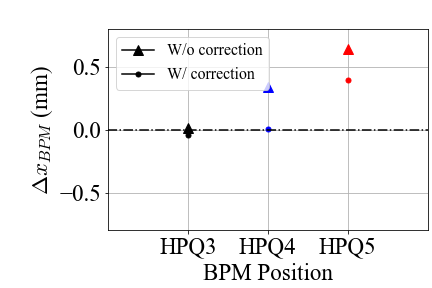

In [122]:
%matplotlib widget

plt.rcParams.update({'font.size': 16, 'font.family': "Times New Roman",
                     'mathtext.fontset': 'cm', 'savefig.format' : 'pdf',
                    'axes.labelsize': 'x-large',
                    'axes.titlesize':'x-large',
                    'xtick.labelsize':'x-large',
                    'ytick.labelsize':'x-large',})


#plt.plot([1],ref['B:HPQ3'],marker='o',markersize=10,markerfacecolor='none',color='k',label='Feb 22 baseline');
plt.plot([1],np.subtract(ref2['B:HPQ3'],ref['B:HPQ3']),marker='^',markersize=10,color='k',label='W/o correction');
plt.plot([1],np.subtract(ref3['B:HPQ3'],ref['B:HPQ3']),marker='.',markersize=10,color='k',label='W/ correction');

#plt.plot([2],ref['B:HPQ4'],marker='o',markersize=10,markerfacecolor='none',color='b');
plt.plot([2],np.subtract(ref2['B:HPQ4'],ref['B:HPQ4']),marker='^',markersize=10,color='b');
plt.plot([2],np.subtract(ref3['B:HPQ4'],ref['B:HPQ4']),marker='.',markersize=10,color='b');

#plt.plot([3],ref['B:HPQ5'],marker='o',markersize=10,markerfacecolor='none',color='r');
plt.plot([3],np.subtract(ref2['B:HPQ5'],ref['B:HPQ5']),marker='^',markersize=10,color='r');
plt.plot([3],np.subtract(ref3['B:HPQ5'],ref['B:HPQ5']),marker='.',markersize=10,color='r');
plt.plot([-1.,5],[0,0],linestyle='-.',color='k')

plt.xticks([1,2,3],labels=['HPQ3','HPQ4','HPQ5'])
plt.xlabel('BPM Position')
plt.ylabel('$\Delta x_{BPM}$ (mm)')
plt.legend(loc='upper left')
plt.grid()
plt.subplots_adjust(bottom=0.2)
plt.subplots_adjust(top=0.90)
plt.subplots_adjust(left=0.25)
plt.subplots_adjust(right=0.99)
plt.xlim(0,4)
plt.ylim(-0.8,0.8)

In [91]:
dfavg3

,L:L7PADJ,L:D64BF,L:D74BF,B:HPQ3,B:HPQ4,B:HPQ5,B:VPQ5,B:HPQ3_E,B:HPQ4_E,B:HPQ5_E,B:VPQ5_E
100,0.0,0.588318,1.031067,0.014037,0.338103,0.638107,0.876952,-19160.379962,-103697.153231,-309571.242381,610382.299794


In [138]:

var = ['B:HPQ5','L:D64BF','L:D74BF']
dpos = [dfavg3[v].values[0] for v in var]

hpq3=3.3858
d74=104.69
d64=43.85274
#dpos = [None]*3
#dpos[0] = hpq3-3.3869
dpos[0]=dpos[0]/1000/D[1]*beta*beta*E_t#+E_kin
#dpos[1] = d64 - 43.1713
#dpos[2] = d74- 107.273
dpos[1] = 2*dpos[1] #402 MHz deg -> 805 MHz deg
dpos[2] = 2*dpos[2] #402 MHz deg -> 805 MHz deg
#print(dpos)
columns = ['endE','initPhi','endPhi']

testdf = pd.DataFrame(dict(zip(columns,dpos)),index=range(len(dfavg3)))
#preds=list(next(zip(*dnn_model.predict(normalizer(pd.DataFrame(dict(zip(var,dpos)),index=range(len(dphase))))))))
#preds=list(next(zip(*dnn_model.predict(pd.DataFrame(dict(zip(var,dpos)),index=range(len(dphase)))))))
#print(preds)

[print(0.75/1000/D[i]*beta*beta*E_t/1.0e6)for i in range(4)]

-1.0237745155893538
-0.2300270348201439
-0.36385499675675687
0.5220205361632654


[None, None, None, None]

In [96]:
train_mean.iloc[1:]
testdf = (testdf-train_mean.iloc[1:]) / train_std.iloc[1:]
testdf

,endE,initPhi,endPhi
0,-0.319144,0.4289,0.526513


In [97]:
testpred = dnn_model.predict(testdf)
scaledEinit = testpred* train_std['initE'] + train_mean['initE']
scaledEinit

array([[-131970.22]], dtype=float32)

In [98]:
p1 = propagate_Nturns(df,67,-29.3,357.1e6-6.66e6)
p2 = propagate_Nturns(df,67,-29.3+1.177,357.1e6-6.798e6)

phaserange1 = gen_scan_range([round(dfavg['L:L7PADJ'].iloc[0],1),
                              round(dfavg['L:L7PADJ'].iloc[-1],1)],
                              round((dfavg['L:L7PADJ'].iloc[1] - dfavg['L:L7PADJ'].iloc[0]),2))

e = (- 6.66 - 0.132)*1e6
p = -29.3 + 1.1766
cav_response_new = phase_scan(phaserange1,df,67,e,p)

In [99]:
print(p1['E'].iloc[0],p2['E'].iloc[0])
print(p1['dPhi'].iloc[0],p2['dPhi'].iloc[0])
print(p1['E'].iloc[-1],p2['E'].iloc[-1])
print(p1['dPhi'].iloc[-1],p2['dPhi'].iloc[-1])

350440000.0 350302000.0
2.6999999999999993 3.876999999999999
401533763.4848698 401400092.75201374
43.38883983016645 45.151852602769566


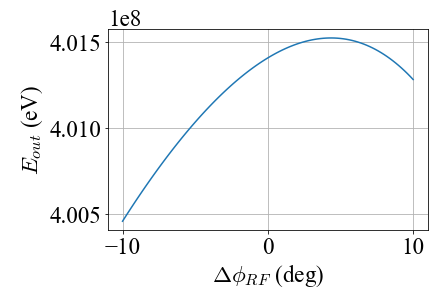

In [104]:
%matplotlib widget
plt.plot(cav_response_new['cavPhi'],cav_response_new['endE'])
plt.ylabel('$E_{out}$ (eV)')
plt.xlabel('$\Delta\phi_{RF}$ (deg)')
plt.grid()

plt.subplots_adjust(bottom=0.2)
plt.subplots_adjust(top=0.90)
plt.subplots_adjust(left=0.25)
plt.subplots_adjust(right=0.99)

In [133]:
cav_response_def = phase_scan(phaserange1,df,67,[0],[0])

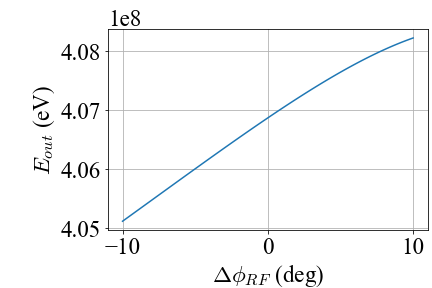

In [134]:
%matplotlib widget
plt.plot(cav_response_def['cavPhi'],cav_response_def['endE'])
plt.ylabel('$E_{out}$ (eV)')
plt.xlabel('$\Delta\phi_{RF}$ (deg)')
plt.grid()

plt.subplots_adjust(bottom=0.2)
plt.subplots_adjust(top=0.90)
plt.subplots_adjust(left=0.25)
plt.subplots_adjust(right=0.99)